In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 1
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 11月 12日 星期一 22:45:38 CST


In [3]:
! ls -l '../data/validate/2018-11-10_01-20-15_noup/' | tail

-rw-rw-r-- 1 meta meta  3828 11月 10 03:35 2018-11-10_03-35-01_565_mcts-mcts_newnet-oldnet_b.cbf
-rw-rw-r-- 1 meta meta  8753 11月 10 03:36 2018-11-10_03-36-11_661_mcts-mcts_oldnet-newnet_peace.cbf
-rw-rw-r-- 1 meta meta  4003 11月 10 03:36 2018-11-10_03-36-46_485_mcts-mcts_oldnet-newnet_w.cbf
-rw-rw-r-- 1 meta meta  8953 11月 10 03:37 2018-11-10_03-37-25_177_mcts-mcts_oldnet-newnet_peace.cbf
-rw-rw-r-- 1 meta meta  7278 11月 10 03:38 2018-11-10_03-38-06_672_mcts-mcts_newnet-oldnet_peace.cbf
-rw-rw-r-- 1 meta meta  3928 11月 10 03:38 2018-11-10_03-38-23_720_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  4828 11月 10 03:38 2018-11-10_03-38-52_609_mcts-mcts_newnet-oldnet_b.cbf
-rw-rw-r-- 1 meta meta  4528 11月 10 03:38 2018-11-10_03-38-53_579_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  6753 11月 10 03:41 2018-11-10_03-41-57_87_mcts-mcts_newnet-oldnet_w.cbf
-rw-rw-r-- 1 meta meta  8303 11月 10 03:45 2018-11-10_03-45-02_674_mcts-mcts_oldnet-newnet_peace.cbf


In [28]:
path = '../data/validate/2018-10-27_02-40-13_noup/'
#path = '../data/distributed/'
#path = '../data/history_selfplays/2018-10-24_08-40-13/'

In [29]:
gameplays = os.listdir(path)

In [30]:
fullpath = '{}{}'.format(path,random.choice(gameplays))
moves = cbf.cbf2move(fullpath)
fname = fullpath.split('/')[-1]
print(fname)
state = gameplay.GameState()

2018-10-27_03-52-33_223_mcts-mcts_oldnet-newnet_w.cbf


In [31]:
from PIL import Image
import imageio
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
for i in moves[:]: 
    statestr = GameBoard.sim_do_action(i,statestr)
    imgs_for_gif.append(board_visualizer.get_board_img(statestr))
    state.do_move(i)
imgs_for_gif = imgs_for_gif[:]
imageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

In [32]:
i,len(moves)

('d8e8', 82)

In [33]:
def display_gif(fn):
    from IPython import display 
    return display.HTML('<img src="{}">'.format(fn))

In [34]:
display_gif('../data/gif/{}.gif'.format(fname[:-4]))

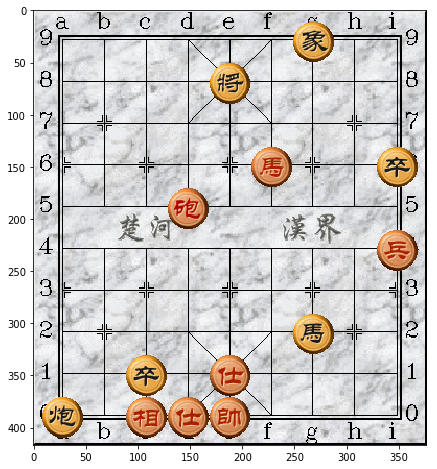

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))

# ANALYSIS

In [ ]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-10-15_14-20-14_noup'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

In [ ]:
network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=400,dnoise=False,c_puct=5)

In [ ]:
network_player.make_move(state=state,actual_move=False)

In [ ]:
network_player.mcts_policy._root._Q

In [ ]:
childs = network_player.mcts_policy._root._children
probs = []
for move in childs:
    val = childs[move]
    print(move,val._n_visits,val._P,val._Q)
    probs.append(val._n_visits)

In [ ]:
plt.plot(probs)
print(probs)

In [ ]:
plt.plot(probs)

In [393]:
sum(probs)

399

In [185]:
datajson = get_km_json(network_player.mcts_policy,state.statestr,depth=40)

In [196]:
!mkdir '../data/mstc_vis'

mkdir: 无法创建目录"../data/mstc_vis": 文件已存在


In [197]:
with open('../data/mstc_vis/sample.km','w') as whdl:
    json.dump(datajson,whdl)